Create a NN network with 5 layers. 

Train and test the model. (2p) 
1) Choose a dataset (CSV or any other image dataset).
2) Utilize the dataloader.
3) Design the NN model.
4) Train and test the model.

I am using Pytorch built In dataset.

Dataset: https://www.robots.ox.ac.uk/~vgg/data/pets/

We have created a 37 category pet dataset with roughly 200 images for each class. The images have a large variations in scale, pose and lighting. All images have an associated ground truth annotation of breed, head ROI, and pixel level trimap segmentation.


Total Images: 3680

In [1]:
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],)
])
pet_dataset = OxfordIIITPet(
    root='datasets/',
    download=True,
    target_types='category',
    transform=transform
)

print(len(pet_dataset))

3680


In [2]:
from pathlib import Path
meta_file = Path(pet_dataset._base_folder) / "annotations" / "list.txt"
with open(meta_file, "r") as f:
    lines = f.readlines()[6:]  # skip header lines

class_name_to_label = {}
label_to_class = {}

for line in lines:
    parts = line.strip().split()
    image_name = parts[0]
    class_name = "_".join(image_name.split("_")[:-1])
    species = "Cat" if int(parts[2]) == 1 else "Dog"
    label = int(parts[1]) - 1  # labels are 1-based in file
    label_to_class[label] = (class_name, species)
    print(class_name, species, label)



Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
Abyssinian Cat 0
american_bulldog Dog 1
american_bulldog Dog 1
american_bulldog Dog 1
american_bulldog Dog 1
american_bulldog Dog 1
american_bulldog Dog 1
american_bul

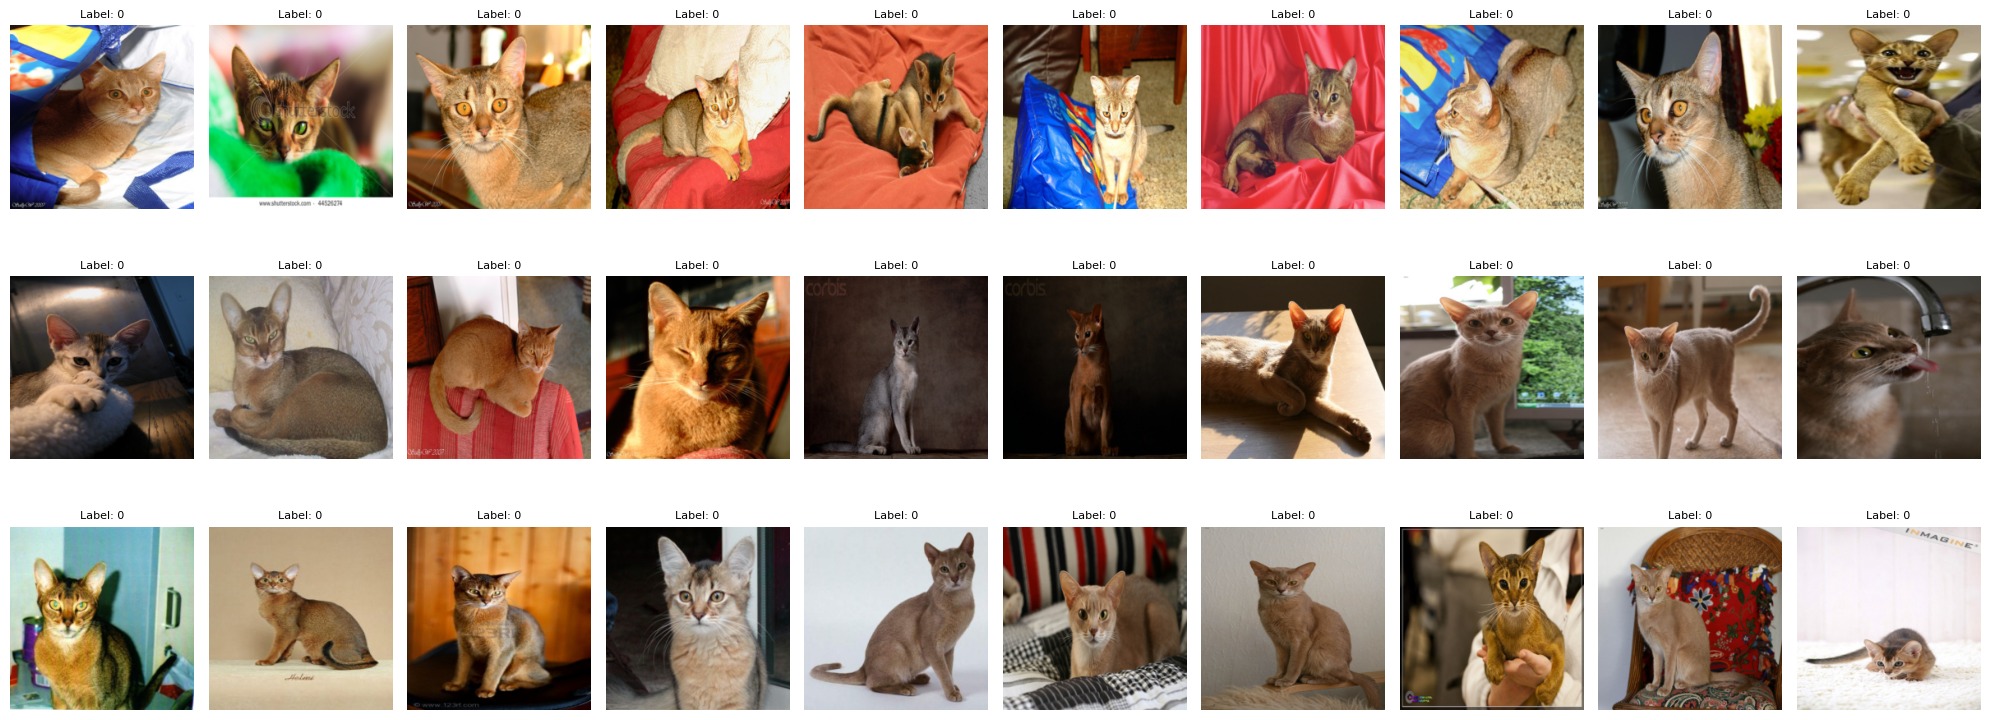

In [3]:
import matplotlib.pyplot as plt

# Set up a 2x10 grid
fig, axes = plt.subplots(3, 10, figsize=(20, 8))

for idx in range(30):
    image, label = pet_dataset[idx]
    ax = axes[idx // 10, idx % 10]  # 2 rows, 10 columns
    ax.imshow(image.permute(1, 2, 0))  # CHW → HWC
    ax.axis("off")
    ax.set_title(f"Label: {label}", fontsize=8)

plt.tight_layout()
plt.show()

In [4]:
import torch
images_dataset = []
labels_dataset = []

for images, labels in pet_dataset:
    images_dataset.append(images)
    labels_dataset.append(labels)

print(len(images_dataset), len(labels_dataset))
images_dataset = torch.stack(images_dataset)
labels_dataset = torch.tensor(labels_dataset)
print(images_dataset.shape, labels_dataset.shape)

3680 3680
torch.Size([3680, 3, 224, 224]) torch.Size([3680])


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images_dataset, labels_dataset, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


torch.Size([2944, 3, 224, 224]) torch.Size([736, 3, 224, 224]) torch.Size([2944]) torch.Size([736])


In [6]:
from torch.utils.data import TensorDataset, DataLoader

dataset_train = TensorDataset(X_train, y_train)
dataset_test = TensorDataset(X_test,y_test)

dataset_train_loader = DataLoader(dataset_train, batch_size=64, shuffle=True)
dataset_test_loader = DataLoader(dataset_test, batch_size=64, shuffle=True)


In [7]:
from torch import nn
class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, output_size)

        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x
    
model = NeuralNet(input_size=224*224*3, output_size=37)


In [8]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
train_loss = []
test_loss = []
epochs = 100

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0.0

    for batch_idx, (images, labels) in enumerate(dataset_train_loader):
        images = images.view(images.size(0), -1)  # Flatten
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(dataset_train_loader)
    train_loss.append(avg_train_loss)

    # Evaluation phase
    model.eval()
    epoch_test_loss = 0.0

    with torch.no_grad():
        for images, labels in dataset_test_loader:
            images = images.view(images.size(0), -1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_test_loss += loss.item()

    avg_test_loss = epoch_test_loss / len(dataset_test_loader)
    test_loss.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}")

Epoch 1/100 | Train Loss: 3.2964 | Test Loss: 3.4744
Epoch 2/100 | Train Loss: 3.2313 | Test Loss: 3.4357
Epoch 3/100 | Train Loss: 3.2432 | Test Loss: 3.4521
Epoch 4/100 | Train Loss: 3.1930 | Test Loss: 3.4126
Epoch 5/100 | Train Loss: 3.1399 | Test Loss: 3.3700
Epoch 6/100 | Train Loss: 3.1182 | Test Loss: 3.4765
Epoch 7/100 | Train Loss: 3.0809 | Test Loss: 3.4972
Epoch 8/100 | Train Loss: 3.0280 | Test Loss: 3.5605
Epoch 9/100 | Train Loss: 3.0562 | Test Loss: 3.4499
Epoch 10/100 | Train Loss: 3.0318 | Test Loss: 3.4184
Epoch 11/100 | Train Loss: 3.0198 | Test Loss: 3.4768
Epoch 12/100 | Train Loss: 2.9443 | Test Loss: 3.5259
Epoch 13/100 | Train Loss: 2.9407 | Test Loss: 3.4910
Epoch 14/100 | Train Loss: 2.9082 | Test Loss: 3.5504
Epoch 15/100 | Train Loss: 2.8550 | Test Loss: 3.6236
Epoch 16/100 | Train Loss: 2.8218 | Test Loss: 3.5582
Epoch 17/100 | Train Loss: 2.7640 | Test Loss: 3.6743
Epoch 18/100 | Train Loss: 2.7776 | Test Loss: 3.6092
Epoch 19/100 | Train Loss: 2.6828 | T

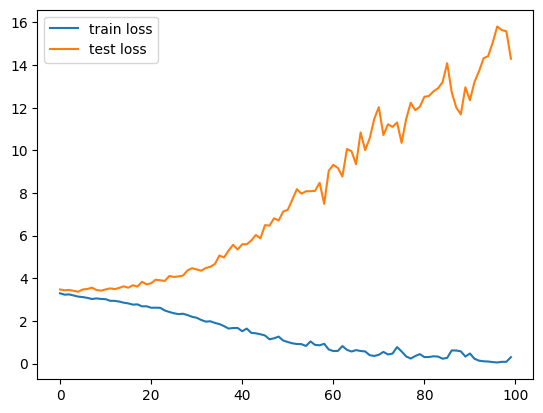

In [12]:
import matplotlib.pyplot as plt
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.legend()
plt.show()

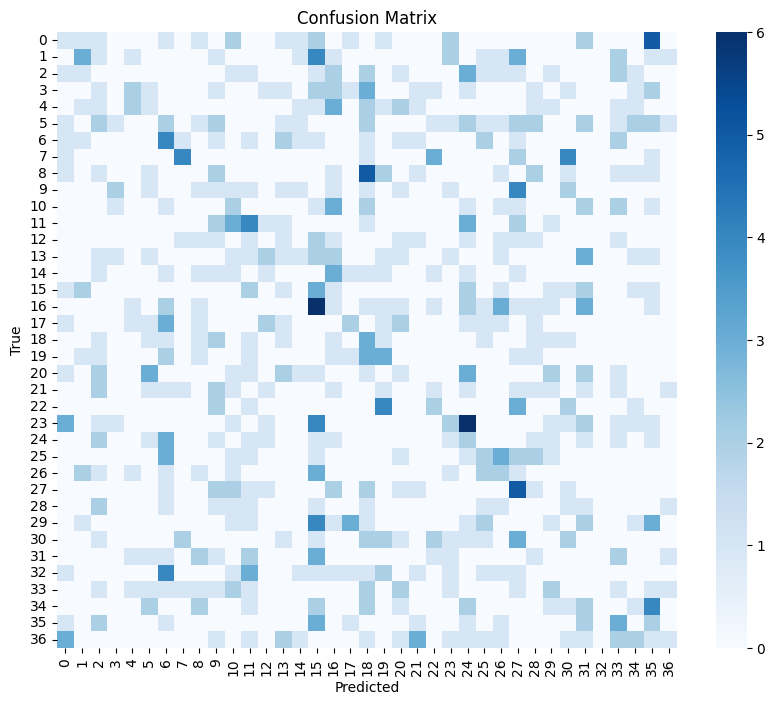

In [18]:
from sklearn.metrics import confusion_matrix

all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for images, labels in dataset_test_loader:
        images = images.view(images.size(0), -1)
        outputs = model(images)
        
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())
        
cm = confusion_matrix(all_targets, all_preds)

import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [15]:
from sklearn.metrics import classification_report

print(classification_report(all_targets, all_preds, target_names=[name for name, _ in label_to_class.values()], zero_division=0))

                            precision    recall  f1-score   support

                Abyssinian       0.06      0.05      0.05        22
          american_bulldog       0.23      0.13      0.17        23
 american_pit_bull_terrier       0.00      0.00      0.00        20
              basset_hound       0.00      0.00      0.00        23
                    beagle       0.20      0.10      0.13        20
                    Bengal       0.00      0.00      0.00        31
                    Birman       0.12      0.19      0.15        21
                    Bombay       0.40      0.25      0.31        16
                     boxer       0.00      0.00      0.00        21
         British_Shorthair       0.04      0.05      0.05        19
                 chihuahua       0.09      0.11      0.10        18
              Egyptian_Mau       0.14      0.22      0.17        18
    english_cocker_spaniel       0.00      0.00      0.00        15
            english_setter       0.06      0.05

In [19]:
torch.save(model.state_dict(), 'lab01.pth')